In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

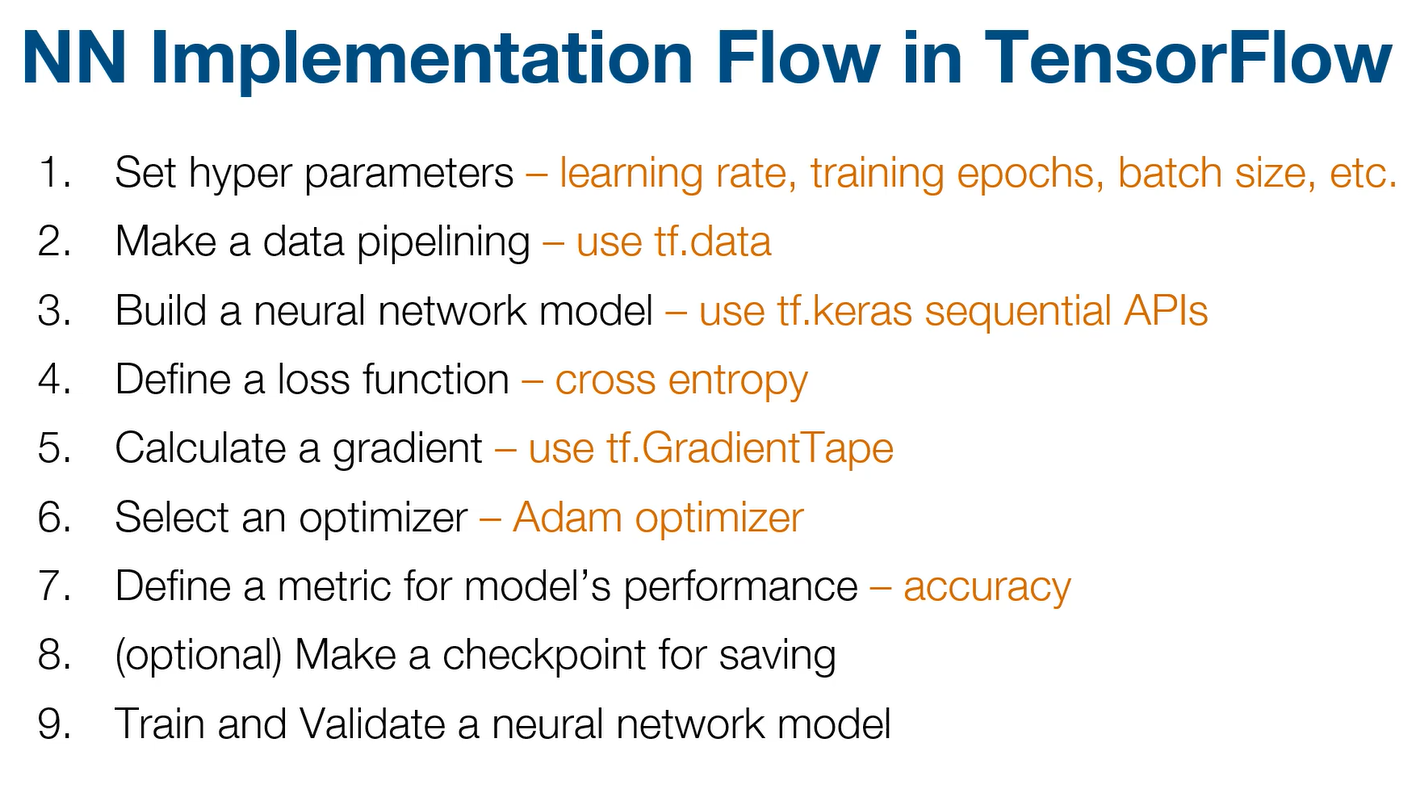

## Importing Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.0


## Hyper Parameters

In [3]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

tf.random.set_seed(777)

## Creating a Checkpoint Directory

In [4]:
cur_dir = os.getcwd()
ckpt_dir_name = 'checkpoints'
model_dir_name = 'minst_cnn_seq'

checkpoint_dir = os.path.join(cur_dir, ckpt_dir_name, model_dir_name)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, model_dir_name)

## MNIST/Fashion MNIST Data

In [5]:
## MNIST Dataset #########################################################
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################

## Datasets

In [6]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()    
    
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)
    
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)    
    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)

## Model Function

In [7]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu, padding='SAME', 
                                  input_shape=(28, 28, 1))) # batch size는 안 써줘도 된다.
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation=tf.nn.relu, padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation=tf.nn.relu))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(10))
    return model

In [8]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

## Loss Function

In [9]:
@tf.function
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
        y_pred=logits, y_true=labels, from_logits=True))    
    return loss   

## Calculating Gradient

In [10]:
@tf.function
def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

## Caculating Model's Accuracy

In [11]:
@tf.function
def evaluate(model, images, labels):
    logits = model(images, training=False)
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

## Optimizer

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

## Creating a Checkpoint

In [13]:
checkpoint = tf.train.Checkpoint(cnn=model)

## Training

In [14]:
@tf.function
def train(model, images, labels):
    grads = grad(model, images, labels)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [15]:
# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_loss = 0.
    avg_train_acc = 0.
    avg_test_acc = 0.
    train_step = 0
    test_step = 0    
    
    for images, labels in train_dataset:
        train(model, images, labels)
        #grads = grad(model, images, labels)                
        #optimizer.apply_gradients(zip(grads, model.variables))
        loss = loss_fn(model, images, labels)
        acc = evaluate(model, images, labels)
        avg_loss = avg_loss + loss
        avg_train_acc = avg_train_acc + acc
        train_step += 1
    avg_loss = avg_loss / train_step
    avg_train_acc = avg_train_acc / train_step
    
    for images, labels in test_dataset:        
        acc = evaluate(model, images, labels)        
        avg_test_acc = avg_test_acc + acc
        test_step += 1    
    avg_test_acc = avg_test_acc / test_step    

    print('Epoch:', '{}'.format(epoch + 1), 'loss =', '{:.8f}'.format(avg_loss), 
          'train accuracy = ', '{:.4f}'.format(avg_train_acc), 
          'test accuracy = ', '{:.4f}'.format(avg_test_acc))
    
    checkpoint.save(file_prefix=checkpoint_prefix)

print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 1 loss = 0.16154166 train accuracy =  0.9593 test accuracy =  0.9850
Epoch: 2 loss = 0.03897562 train accuracy =  0.9905 test accuracy =  0.9910
Epoch: 3 loss = 0.02470518 train accuracy =  0.9937 test accuracy =  0.9920
Epoch: 4 loss = 0.01770569 train accuracy =  0.9954 test accuracy =  0.9917
Epoch: 5 loss = 0.01397348 train accuracy =  0.9966 test accuracy =  0.9927
Epoch: 6 loss = 0.01104618 train accuracy =  0.9976 test accuracy =  0.9925
Epoch: 7 loss = 0.00798379 train accuracy =  0.9982 test accuracy =  0.9937
Epoch: 8 loss = 0.00755127 train accuracy =  0.9984 test accuracy =  0.9940
Epoch: 9 loss = 0.00586086 train accuracy =  0.9987 test accuracy =  0.9906
Epoch: 10 loss = 0.00505105 train accuracy =  0.9990 test accuracy =  0.9927
Epoch: 11 loss = 0.00421452 train accuracy =  0.9992 test accuracy =  0.9927
Epoch: 12 loss = 0.00316157 train accuracy =  0.9994 test accuracy =  0.9940
Epoch: 13 loss = 0.00295359 train accuracy =  0.

## Functional API

In [16]:
inputs = keras.Input(shape = (28,28, 256))
conv1 = keras.layers.Conv2D(filters = 64, kernel_size = 1, padding = 'SAME', 
                           activation = keras.layers.ReLU())(inputs)
conv2 = keras.layers.Conv2D(filters = 256, kernel_size = 3, padding = 'SAME', 
                           activation = keras.layers.ReLU())(conv1)
add3 = keras.layers.add([conv2, inputs])
relu3 = keras.layers.ReLU()(add3)
model_functional = keras.Model(inputs, relu3)